In [8]:
import re
import nltk
import random
import numpy as np
import pandas as pd
from textblob import Word
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [9]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/cesarpantoja/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
!python3 -m textblob.download_corpora

[nltk_data] Downloading package brown to
[nltk_data]     /Users/cesarpantoja/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cesarpantoja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cesarpantoja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/cesarpantoja/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/cesarpantoja/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/cesarpantoja/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


## Data preparation

In [11]:
def count_samples_per_cat(samples, cats):
    counts = {}
    for name in cats:
        counts[name] = 0

    for corpus, label in samples:
        counts[label] += 1

    return counts

def read_json_kaggle():
    with open('kaggle_dataset.json') as json_file:
        data = json.load(json_file)

    return data['articles']

def get_data():
    categories = []
    dates = []

    categorias_unicas = list(set(categories))
    dates_list = list(set(dates))

    data = read_json_kaggle()

    for dct in data:
        categories.append(dct['category'])

    for dct in data:
        if dct['category'] in ['POLITICS', 'ENTERTAINMENT']:
            dates.append(datetime.strptime(dct['date'], "%Y-%m-%d").strftime("%d-%m-%Y"))

    print("-------------------")
    print("- Análisis  en el conjunto de datos -")
    print("-------------------")
    print(f'tenemos  {len(categorias_unicas)} categorias')
    print(categorias_unicas)
    print("-------------------")
    print('la fecha más actualizada del data set es : ' + str(max(dates)))
    print("-------------------")
    print(
        "- Tómaremos  las categorías -- > TECH, ENTERTAINMENT, BUSINESS, SPORTS, SCIENCE, POLITICS- y datos más actuales, la fecha mayores de 01-01-2017")
    print("-------------------")


    filtered_data = []
    filter_date = datetime.strptime('2017-01-01', "%Y-%m-%d")
    allowed_categories = {'TECH': 0, 'ENTERTAINMENT': 0, 'BUSINESS': 0, 'SPORTS': 0, 'SCIENCE': 0, 'POLITICS': 0}
    for dct in data:
        if dct['category'] in allowed_categories:
            datetime_object = datetime.strptime(dct['date'], '%Y-%m-%d')
            if dct['category'] in ['POLITICS', 'ENTERTAINMENT']:
                if datetime_object >= filter_date:
                    filtered_data.append(dct)
                    allowed_categories[dct['category']] += 1
            else:
                filtered_data.append(dct)
                allowed_categories[dct['category']] += 1

    print(allowed_categories)
    print("--")

    politics = []
    entertainment = []
    tech = []
    business = []
    sports = []
    science = []
    for dct in filtered_data:
        if dct['category'] == "POLITICS":
            politics.append(tuple((str(dct['headline']) + '. ' + str(dct['short_description']), "POLITICS")))
        if dct['category'] == "ENTERTAINMENT":
            entertainment.append(tuple((str(dct['headline']) + '. ' + str(dct['short_description']), "ENTERTAINMENT")))
        if dct['category'] == "TECH":
            tech.append(tuple((str(dct['headline']) + '. ' + str(dct['short_description']), "TECH")))
        if dct['category'] == "BUSINESS":
            business.append(tuple((str(dct['headline']) + '. ' + str(dct['short_description']), "BUSINESS")))
        if dct['category'] == "SPORTS":
            sports.append(tuple((str(dct['headline']) + '. ' + str(dct['short_description']), "SPORTS")))
        if dct['category'] == "SCIENCE":
            science.append(tuple((str(dct['headline']) + '. ' + str(dct['short_description']), "SCIENCE")))

    max_samples = 2000
    politics = random.sample(politics, max_samples)
    entertainment = random.sample(entertainment, max_samples)
    business = random.sample(business, max_samples)
    sports = random.sample(sports, max_samples)
    science = random.sample(science, max_samples)
    tech = random.sample(tech, max_samples)
    articles = politics + entertainment + business + sports + science + tech
    print(
        count_samples_per_cat(articles, ['TECH', 'ENTERTAINMENT', 'BUSINESS', 'SPORTS', 'SCIENCE', 'POLITICS']))
    return articles



def clean_string(string):

    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]", "", string)
    string = re.sub(r"\s{2,}", " ", string)

    return string.strip().lower()


def prepare_dataset(dataset):
    # divide in features and labels
    x = dataset['news'].tolist()
    y = dataset['type'].tolist()
    print("\n--------------------------------------------------------")
    print("------------------- DATA PREPARATION -------------------")
    print("--------------------------------------------------------\n")
    print("Tokenization & lemmatization", end='', flush=True)
    for i, value in enumerate(x):
        x[i] = ' '.join([Word(word).lemmatize() for word in clean_string(value).split()])
        if i % 100 == 0:
            print('.', end='', flush=True)
    print("DONE!\n")
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

    vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

    X_train = vect.fit_transform(X_train)
    y_train = np.array(y_train)
    X_test = vect.transform(X_test)
    y_test = np.array(y_test)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

    print("Train set:" + str(X_train.shape))
    print("Validation set:" + str(X_val.shape))
    print("Test set:" + str(X_test.shape))

    return X_train, X_val, X_test, y_train, y_val, y_test, vect

## Models

In [12]:

def train_RF(X_train, y_train):
    print("-------------------")
    print("-- RANDOM FOREST --")
    print("-------------------")
    model = RandomForestClassifier(n_estimators=300, max_depth=150, n_jobs=1)
    model.fit(X_train, y_train)
    return model


def train_NN(X_train, y_train):
    print("-------------------")
    print("- NEURAL  NETWORK -")
    print("-------------------")
    model = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
                          beta_1=0.9, beta_2=0.999, early_stopping=True,
                          epsilon=1e-08, hidden_layer_sizes=(128, 64),
                          learning_rate='constant', learning_rate_init=0.001,
                          max_iter=400, momentum=0.9, n_iter_no_change=10,
                          nesterovs_momentum=True, power_t=0.5, random_state=1,
                          shuffle=True, solver='lbfgs', tol=0.0001,
                          validation_fraction=0.1, verbose=False, warm_start=False)
    model.fit(X_train, y_train)
    return model


def train_SVC(X_train, y_train):
    print("-------------------")
    print("------- SVM -------")
    print("-------------------")
    model = SVC(kernel='linear', gamma='auto')
    model.fit(X_train, y_train)
    return model


def eval_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    result = classification_report(y_val, y_pred)
    accSVC = accuracy_score(y_val, y_pred)
    print(result)
    print("\nAccuracy: ", accSVC)


def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

## Configuration 

In [13]:
PREFERENCES = ["TECH", "ENTERTAINMENT", "BUSINESS", "SPORTS", "SCIENCE", "POLITICS"]

class bcolors:
    PURPLE = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


def assign_preferences(users):
    users_with_preferences = {}
    for user in users:
        preferences = []
        possibilities = list(PREFERENCES)
        for pref in range(random.randint(1, 3)):
            category = random.choice(possibilities)
            preferences.append(category)
            possibilities.remove(category)
        users_with_preferences[user] = preferences
    return users_with_preferences


def predict_doc_type(doc, vect, model):
    doc_cleaned = clean_string(doc)
    corpus = []
    corpus.append(doc_cleaned)
    test_vect = vect.transform(corpus)
    return model.predict(test_vect)[0]


# Testing results
def run_demo(vect, model):
    users = ["Silvia   ", "Cinthia   ", "Cesar    ", "Alexander    ", "Julissa     ", "Mike    "]
    users_with_preferences = assign_preferences(users)
    print("\n--------------------------------------------------------")
    print("------------------------- DEMO -------------------------")
    print("--------------------------------------------------------\n")

    print("--------------------------------------------------------\n")
    print("USER PREFERENCES:")
    for user in users_with_preferences:
        print(user, " -> ", users_with_preferences[user])
    print("\n--------------------------------------------------------")

    while True:
        try:
            print("---------------------------------------------------------------------------------------------------------------")
            test_corpus = input(bcolors.BOLD + "Paste here an article without newline characters (\\n) (Press 'q' to quit or 'r' to reassign the preferences):\n" + bcolors.ENDC)
            print("---------------------------------------------------------------------------------------------------------------")
        except ValueError:
            continue
        if test_corpus == "q":
            break
        if test_corpus == "r":
            users_with_preferences = assign_preferences(users)
            print("--------------------------------------------------------\n")
            print("USER PREFERENCES:")
            for user in users_with_preferences:
                print(user, "->  ", users_with_preferences[user])
            print("\n--------------------------------------------------------")
            continue
        else:

            result = predict_doc_type(test_corpus, vect, model)
            if(result == "business"):
                topic = bcolors.BOLD + bcolors.YELLOW + result.upper() + bcolors.ENDC
            if (result == "entertainment"):
                topic = bcolors.BOLD + bcolors.RED + result.upper() + bcolors.ENDC
            if (result == "politics"):
                topic = bcolors.BOLD + bcolors.PURPLE + result.upper() + bcolors.ENDC
            if (result == "sport"):
                topic = bcolors.BOLD + bcolors.BLUE + result.upper() + bcolors.ENDC
            if (result == "tech"):
                topic = bcolors.BOLD + bcolors.GREEN + result.upper() + bcolors.ENDC
            print("--------------------------------------------------------\n")
            print(bcolors.BOLD + "This article talks about "+ topic + bcolors.BOLD + " and it's addressed to:"+bcolors.ENDC)
            for user in users_with_preferences:
                if result in users_with_preferences[user]:
                    print(user)
            print("\n--------------------------------------------------------")
            continue

## Main

-------------------
- Análisis  en el conjunto de datos -
-------------------
tenemos  0 categorias
[]
-------------------
la fecha más actualizada del data set es : 31-12-2017
-------------------
- Tómaremos  las categorías -- > TECH, ENTERTAINMENT, BUSINESS, SPORTS, SCIENCE, POLITICS- y datos más actuales, la fecha mayores de 01-01-2017
-------------------
{'TECH': 2082, 'ENTERTAINMENT': 4910, 'BUSINESS': 5937, 'SPORTS': 4884, 'SCIENCE': 2178, 'POLITICS': 13680}
--
{'TECH': 2000, 'ENTERTAINMENT': 2000, 'BUSINESS': 2000, 'SPORTS': 2000, 'SCIENCE': 2000, 'POLITICS': 2000}
-------------------
- Análisis  en el conjunto de datos -
-------------------
tenemos  0 categorias
[]
-------------------
la fecha más actualizada del data set es : 31-12-2017
-------------------
- Tómaremos  las categorías -- > TECH, ENTERTAINMENT, BUSINESS, SPORTS, SCIENCE, POLITICS- y datos más actuales, la fecha mayores de 01-01-2017
-------------------
{'TECH': 2082, 'ENTERTAINMENT': 4910, 'BUSINESS': 5937, 'SPO

/Users/cesarpantoja/Documents/master_ai/virtual-enviroment/nn_practice-02/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


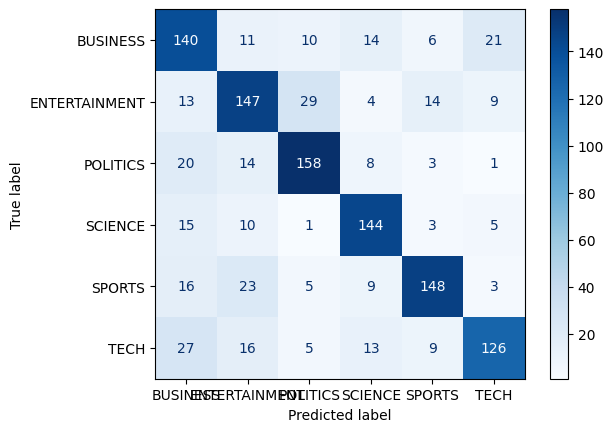

-------------------
------- SVM -------
-------------------
               precision    recall  f1-score   support

     BUSINESS       0.71      0.74      0.73       206
ENTERTAINMENT       0.81      0.81      0.81       210
     POLITICS       0.80      0.85      0.82       198
      SCIENCE       0.87      0.86      0.86       194
       SPORTS       0.87      0.85      0.86       177
         TECH       0.80      0.73      0.77       215

     accuracy                           0.81      1200
    macro avg       0.81      0.81      0.81      1200
 weighted avg       0.81      0.81      0.81      1200


Accuracy:  0.805


/Users/cesarpantoja/Documents/master_ai/virtual-enviroment/nn_practice-02/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


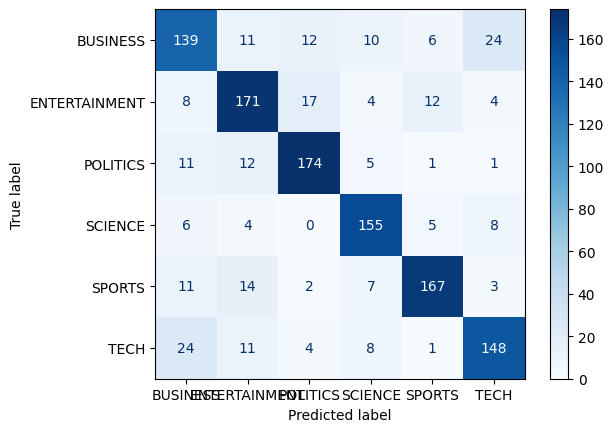

-------------------
- NEURAL  NETWORK -
-------------------


/Users/cesarpantoja/Documents/master_ai/virtual-enviroment/nn_practice-02/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/cesarpantoja/Documents/master_ai/virtual-enviroment/nn_practice-02/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


               precision    recall  f1-score   support

     BUSINESS       0.72      0.70      0.71       206
ENTERTAINMENT       0.77      0.83      0.80       210
     POLITICS       0.78      0.80      0.79       198
      SCIENCE       0.84      0.87      0.85       194
       SPORTS       0.85      0.84      0.85       177
         TECH       0.79      0.71      0.75       215

     accuracy                           0.79      1200
    macro avg       0.79      0.79      0.79      1200
 weighted avg       0.79      0.79      0.79      1200


Accuracy:  0.79


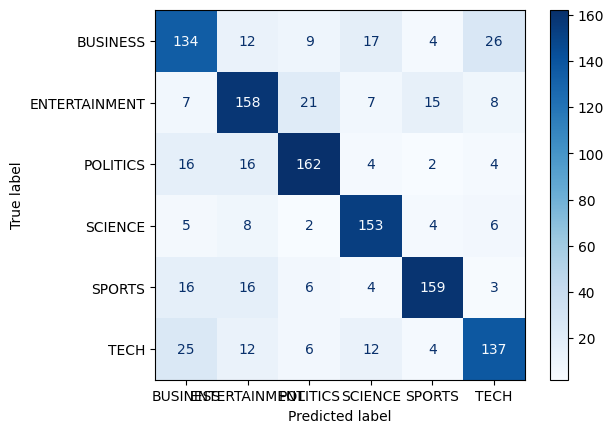


--------------------------------------------------------
-------------- MODELS  TESTING (accuracy) --------------
--------------------------------------------------------

RANDOM FOREST:      0.7191666666666666
SVC:                0.795
NEURAL NETWORK:     0.7525


In [14]:
# DATA PREPARATION
data_kaggle = pd.DataFrame(get_data(), columns=['news', 'type'])
#dataset = pd.read_csv('dataset.csv', encoding="ISO-8859-1")
dataset = pd.DataFrame(get_data(), columns=['news', 'type'])
X_train, X_val, X_test, y_train, y_val, y_test, vect = prepare_dataset(dataset)

# MODELS TRAINING
print("\n--------------------------------------------------------")
print("------------------- MODELS  TRAINING -------------------")
print("--------------------------------------------------------\n")

# Random Forest
modelRF = train_RF(X_train, y_train)
eval_model(modelRF, X_val, y_val)
plot_confusion_matrix(modelRF, X_test, y_test, cmap='Blues')
plt.show()
# SVM
modelSVC = train_SVC(X_train, y_train)
eval_model(modelSVC, X_val, y_val)
plot_confusion_matrix(modelSVC, X_test, y_test, cmap='Blues')
plt.show()
# NN
modelNN = train_NN(X_train, y_train)
eval_model(modelNN, X_val, y_val)
plot_confusion_matrix(modelNN, X_test, y_test, cmap='Blues')
plt.show()

# MODELS TESTING
print("\n--------------------------------------------------------")
print("-------------- MODELS  TESTING (accuracy) --------------")
print("--------------------------------------------------------\n")
print("RANDOM FOREST:     ", test_model(modelRF, X_test, y_test))
print("SVC:               ", test_model(modelSVC, X_test, y_test))
print("NEURAL NETWORK:    ", test_model(modelNN, X_test, y_test))


In [15]:
# RUN THE DEMO
run_demo(vect, modelNN)


--------------------------------------------------------
------------------------- DEMO -------------------------
--------------------------------------------------------

--------------------------------------------------------

USER PREFERENCES:
Maria     ->  ['sport']
Nacho     ->  ['business']
Luca      ->  ['entertainment', 'sport', 'business']
Adam      ->  ['tech', 'politics', 'business']
Tom       ->  ['sport', 'entertainment', 'politics']
Mike      ->  ['business']

--------------------------------------------------------
---------------------------------------------------------------------------------------------------------------



KeyboardInterrupt

